# Model with biomass reaction to predict steady-state concentrations

## Goal

**Estimate the photosynthetic output of an average *Synechocystis* sp. PCC 6803 cell as input into another model**

## Plan

First option: Use the submitted model version. The model is unalterend (not reduced in size) and the cellular chlorophyll a concentration is only considered for normalizing the pigment concentrations.

### Input
- Light spectrum & intensity (400-700 nm)
- Pigment concentrations: Chlorophyll A, beta-carotene (carotenoids), phycocyanin, and allophycocyanin
- Chlorophyll concentration in sample cuvette

### Output

Concentrations of ATP, NADPH, 3PGA

In [9]:
import pandas as pd
import numpy as np
from pathlib import Path
import sys
import os
from functools import partial
from concurrent.futures import ProcessPoolExecutor
from tqdm.auto import tqdm
import warnings

from modelbase.ode import Simulator
from modelbase.ode import ratefunctions as rf

sys.path.append("../Code")
import functions as fnc
import calculate_parameters_restruct as prm
import functions_light_absorption as lip

# Import model functions
from get_current_model import get_model

from functions_custom_steady_state_simulator import simulate_to_steady_state_custom
from scipy.integrate import simpson
import parameters

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import mean_squared_error
from datetime import datetime

# Import the email notifyer
from SMTPMailSender import SMTPMailSender

# Set 
max_workers = 100
max_workers = np.min([max_workers, os.cpu_count() - 2])
file_prefix = f"concregression_{datetime.now().strftime('%Y%m%d%H%M')}"
n_points = 3

# # Setup the email sender
# email = SMTPMailSender(
#     SMTPserver='mail.gmx.net',
#     username='tobiaspfennig@gmx.de',
#     default_destination='tobiaspfennig@gmx.de'
# )

# email.send_email(
#     body=f"Regression run {file_prefix} was successfully started",
#     subject="Regression started"
# )

# Define OCP activation as active, light involved process with passive reversal
def OCPactivation(
    OCP, light_ocp, kOCPactivation, kOCPdeactivation, lcf, OCPmax=1
):  # >> changed: added <<
    return (
        light_ocp * lcf * kOCPactivation * (OCPmax - OCP)
        - kOCPdeactivation * OCP
    )


# Add OCP effect on light absorption
def ps_normabsorption_ocp(time, PBS_PS1, PBS_PS2, OCP, complex_abs_ps1, complex_abs_ps2, complex_abs_pbs, PSItot, PSIItot, lcf):
    light_ps1 = (complex_abs_ps1 + complex_abs_pbs * PBS_PS1 * (1 - OCP)) / PSItot
    light_ps2 = (
        complex_abs_ps2 + complex_abs_pbs * PBS_PS2 * (1 - OCP)
    ) / PSIItot

    if isinstance(light_ps2, float) and isinstance(
        time, np.ndarray
    ):  # >> changed: added <<
        light_ps1 = np.repeat(light_ps1, len(time))
        light_ps2 = np.repeat(light_ps2, len(time))

    return light_ps1 * lcf, light_ps2 * lcf  # Get float values


def make_light_into_input(m, y0={}, init_param=None, verbose=True):
    if verbose:
        print("making absorption direct input")

    # Add the light parameters that were added as direct inputs
    p = {
        "complex_abs_ps1": 1,
        "complex_abs_ps2": 1,
        "complex_abs_pbs": 1,
        "light_ocp": 1,
    }

    m.add_parameters(p)

    # Remove unnecessary reactions and parameters
    m.remove_derived_parameter("complex_abs")
    m.remove_parameter("pfd")
    

    # Add OCP activation
    m.update_reaction_from_args(  # >> changed: added <<
        rate_name="OCPactivation",
        function=OCPactivation,
        stoichiometry={"OCP": 1},
        args=["OCP", "light_ocp", "kOCPactivation", "kOCPdeactivation", "lcf", "OCPmax"],
    )

    # >> changed: replaced calculate_excite_ps and the depricated light function with an updated ps_normabsorption <<
    # Add the calculation of normalised absorption by the photosystems
    # Includes PBS association and OCP
    m.update_algebraic_module(
        module_name="ps_normabsorption",
        function=ps_normabsorption_ocp,
        args=["time", "PBS_PS1", "PBS_PS2", "OCP", "complex_abs_ps1", "complex_abs_ps2", "complex_abs_pbs", "PSItot", "PSIItot", "lcf"],
        check_consistency=False,
    )

    # Sort the algebraic modules (temporary until bug is fixed)
    # m = sort_algmodules(m)
    return m, y0


# Get the model and add the biomass reaction
# Get the default model
_m = get_model(get_y0=False, verbose=False, check_consistency=False)

stoich_3PGA = pd.Series({
    "CO2": -3,
    "ATP": -8,
    "NADPH": -5,
    "3PGA": 1,
})

# Biomass stoichiometry as given in Knoop2015
# This reaction has to complete once for a full division
biomass_Knoop2015 = pd.Series({ # [mmol gDW(Biomass)^-1]
    "NADPH": -90, 
    "ATP": -191,
    "CO2": -41.5,
    
    "3PGA": 0, # Added for compliance with the model
})

# Transform to usage of 3PGA
biomass_Knoop2015 = biomass_Knoop2015 - (stoich_3PGA / stoich_3PGA["CO2"] * biomass_Knoop2015["CO2"])
biomass_Knoop2015 = biomass_Knoop2015.drop("CO2")
biomass_Knoop2015["Ho"] = biomass_Knoop2015["NADPH"] / _m.get_parameter("bHo")

# Calculate the conversion from gDW to mol(Chl)
mChl_DW = 10 # [mg gDW^-1] (Zavrel2019)
MChl = 893.509 # [g mol^-1]

nChl_DW = ( # [mol gDW^-1]
    mChl_DW 
    * 1e-3 # [g mg^-1]
    / MChl # [g mol^-1]
)

# Scale the biomass stoichiometry to mol Chl
biomass_Knoop2015 = biomass_Knoop2015 / nChl_DW # [mmol mol(Chl)^-1]


# Get the growth rate of the 633nm (red)-light grown cells
growth_rate = pd.read_csv("../Code/data/Strainparameters_Zavrel2021.csv", header=0,skiprows=1, index_col=0).loc["Specific growth rate","633"] # [h^-1]
growth_rate = growth_rate / 3600 # [s^-1]

# Get the default model
m, y0 = get_model(verbose=False, check_consistency=False)

# Set the initial 3PGA concentration to zero
y0["3PGA"] = 0

# Add a biomass reaction as Mass action
biomass_stoich = biomass_Knoop2015.to_dict()

# Add parameter(s) and reaction to model
m.add_parameter("k_biomass", growth_rate * 10)
m.add_reaction_from_args(
    "vBiomass",
    function = rf.mass_action_variable,
    stoichiometry = biomass_stoich,
    args = ["k_biomass"] + list(biomass_stoich.keys()),
)

m, y0 = make_light_into_input(m, y0)

# %%
# Generate the input light data
_light_input = np.linspace(10, 1000, n_points)

light_input = np.array(np.meshgrid(
    _light_input,
    _light_input,
    _light_input,
    _light_input,
)).T.reshape(-1,4)

light_input = pd.DataFrame(
    light_input,
    columns = [
        "complex_abs_ps1",
        "complex_abs_ps2",
        "complex_abs_pbs",
        "light_ocp"
    ]
)

light_input.shape[0]

# %%
def get_ss_rates(x, p_keys, m, y0, compounds=["ATP", "NADPH", "3PGA", "Fd_red"], file_prefix=file_prefix):
    index, p_values = x

    # Adapt and initialise the simulator
    s = Simulator(m)
    p = dict(zip(p_keys, p_values.to_numpy()))
    s.update_parameters(p)
    s.initialise(y0)

    # print(index, p)

    integrator_kwargs = {
        "maxsteps": 20000,
        "atol": 1e-9,
        "rtol": 1e-9,
        "maxnef": 10,
        "maxncf": 10,
    }

    # Simulate to steady state
    s, t, y = simulate_to_steady_state_custom(
        s,
        simulation_kwargs={
            "t_end": 1e6,
            "tolerances": [[["CBBa", "PSII", "OCP"], 1e-8], [None, 1e-6]],
            "verbose": False,
        },
        rel_norm=True,
        return_simulator=True,
        **integrator_kwargs,
    )

    # Get the concentrations 
    if t is not None:
        res = s.get_full_results_df()
        conc = res.loc[:, compounds].iloc[-1]
    else:
        conc = pd.Series(index=compounds)

    # Save the residuals
    with open(Path(f"../out/{file_prefix}_intermediates.csv",), "a") as f:
        f.writelines(f"{index},{','.join([str(x) for x in p_values])},{','.join([str(x) for x in conc.to_numpy()])}\n")

    return conc


# # Partially populate the function
# _get_outputs = partial(
#     get_outputs,
#     p_keys=light_input.columns,
#     m=m,
#     y0=y0,
# )

# # %%
# input = light_input.iterrows()# .to_numpy()


# with warnings.catch_warnings():
#     warnings.simplefilter("ignore")
    
#     with ProcessPoolExecutor(max_workers=max_workers) as pe:
#         res = list(tqdm(
#             pe.map(_get_outputs, input),
#             total=light_input.shape[0],
#             disable=False
#         ))

# result = pd.concat(res, axis=1).T.reset_index().drop("index", axis=1)
# n_successful = np.invert(result.isna().any(axis=1)).sum()

# # Save the parameters and results
# light_input.to_csv(Path(f"../Results/{file_prefix}_params.csv",))
# result.to_csv(Path(f"../Results/{file_prefix}_results.csv",))

# email.send_email(
#     body=f"Regression run {file_prefix} was successfully finished\n{n_successful} simulations were successful",
#     subject="Regression finished"
# )

making absorption direct input


## Fit the regression function

In [10]:
import matplotlib.pyplot as plt

In [11]:
run_prefix = "concregression_202405282039"

result = pd.read_csv(f"../Results/{run_prefix}_results.csv", index_col=0)
input = pd.read_csv(f"../Results/{run_prefix}_params.csv", index_col=0)

In [12]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import mean_squared_error

# Exclude the failed simulations
failed_simulations = result.isna().any(axis=1)

# Generate some sample data
X = input[np.invert(failed_simulations)]
y = result.loc[np.invert(failed_simulations), :].to_numpy()

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Degree of the polynomial
degree = 5

# Create polynomial features
polynomial_features = PolynomialFeatures(degree=degree)

# Create a base regressor
base_regressor = LinearRegression()

# Wrap the regressor with MultiOutputRegressor
multi_target_regressor = MultiOutputRegressor(base_regressor)

# Create a pipeline that combines the polynomial features and the linear regression model
model = make_pipeline(polynomial_features, multi_target_regressor)

# Fit the model
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse}")

Mean Squared Error: 0.32623867727460565


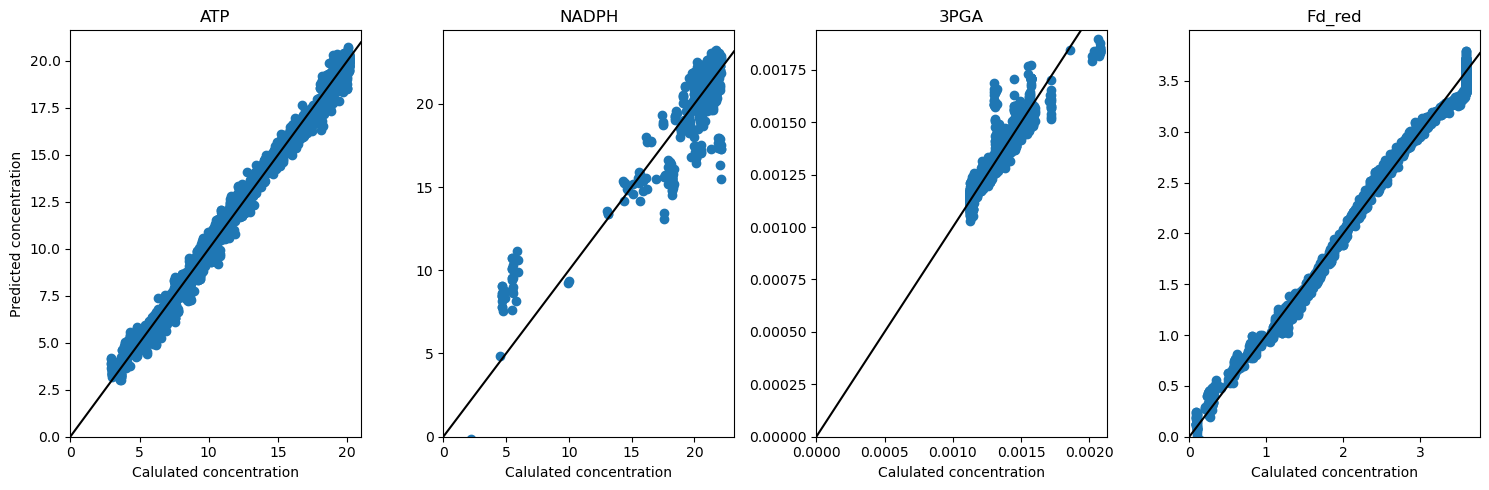

In [13]:
fig, axes = plt.subplots(1,4, figsize=(15,5))

for i, ax in enumerate(axes.flatten()):
    ax.plot(y_test[:,i], y_pred[:,i], ls="", marker="o")
    ax.set_xlabel("Calulated concentration")
    if i == 0:
        ax.set_ylabel("Predicted concentration")
    ax.set_xlim(0)
    ax.set_ylim(0)
    ax.set_title(result.columns[i])

    min_lim, maxlim = np.array([ax.get_ylim(), ax.get_xlim()]).min(axis=0)

    ax.plot((min_lim, maxlim), (min_lim, maxlim), c="k")

fig.tight_layout()

In [14]:
# import pickle
# with open("../Results/concentration_regression_model.pickle", "wb") as f:
#     pickle.dump(model, f)

# Photosynthesis estimation function

## Goal

**Estimate the photosynthetic output of an average *Synechocystis* sp. PCC 6803 cell as input into another model**

## Plan

First option: Use the submitted model version. The model is unalterend (not reduced in size) and the cellular chlorophyll a concentration is only considered for normalizing the pigment concentrations.

### Input
- **Light intensity & spectrum (400-700 nm)**
- Pigment concentrations: **Chlorophyll A, beta-carotene (carotenoids), phycocyanin, and allophycocyanin**
- Use the **measured absorption spectrum to calculate the light attenuation**
- NOT Chlorophyll concentration in sample cuvette BUT **Cell density in cells/ml**

### Output

NOT Concentrations BUT **Rates of ATP, NADPH, 3PGA, Fd_red**

In [146]:
import pandas as pd
import numpy as np
from pathlib import Path
import sys
import os
from functools import partial
from concurrent.futures import ProcessPoolExecutor
from tqdm.auto import tqdm
import warnings

from modelbase.ode import Simulator
from modelbase.ode import ratefunctions as rf

sys.path.append("../Code")
import functions as fnc
import calculate_parameters_restruct as prm
import functions_light_absorption as lip

# Import model functions
from get_current_model import get_model

from functions_custom_steady_state_simulator import simulate_to_steady_state_custom
from scipy.integrate import simpson
import parameters

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import mean_squared_error
from datetime import datetime

import traceback
import logging

import pebble
from concurrent import futures

from function_concentration_regression import make_light_into_input

# Import the email notifyer
from SMTPMailSender import SMTPMailSender

# Set 
max_workers = 100
max_workers = np.min([max_workers, os.cpu_count() - 2])
file_prefix = f"rateregression_{datetime.now().strftime('%Y%m%d%H%M')}"
n_points = 2

target_compounds = ["ATP", "NADPH", "3PGA", "Fd_red"]

# Setup the email sender
email = SMTPMailSender(
    SMTPserver='mail.gmx.net',
    username='tobiaspfennig@gmx.de',
    default_destination='tobiaspfennig@gmx.de'
)

email.send_email(
    body=f"Regression run {file_prefix} was successfully started",
    subject="Regression started"
)

formatter = logging.Formatter('%(asctime)s %(levelname)s %(message)s')
def setup_logger(name, log_file, level=logging.INFO):
    """To setup as many loggers as you want"""

    logger = logging.getLogger(name)
    logger.setLevel(level)

    if len(logger.handlers) == 0:
        handler = logging.FileHandler(log_file)        
        handler.setFormatter(formatter)
        logger.addHandler(handler)

    return logger

# %%
# Generate the input light data
_light_input = np.linspace(10, 1000, n_points)

_m = get_model(get_y0=False, verbose=False, check_consistency=False)

## Get the values of the varied pigment contents
# Get the pigments in the default model
_m = get_model(get_y0=False, verbose=False, check_consistency=False)
pigments = _m.parameters["pigment_content"]
_index = pigments.index

# Get onl the non-chlorophll compounds and reshape to allow for dot product
pigments = pigments.iloc[1:].to_numpy().reshape(-1,1)


# Make dot product with vector sapling a range of possible values 
pigments = pigments.dot(np.logspace(-np.log10(5), np.log(5), n_points).reshape(1,-1))
pigments = pd.DataFrame(pigments, index = _index[1:]).T

light_input = np.array(np.meshgrid(
    _light_input, # complex_abs_ps1
    _light_input, # complex_abs_ps2
    _light_input, # complex_abs_pbs
    _light_input, # light_ocp
    pigments["phycocyanin"], # phycocyanin
    pigments["allophycocyanin"], # allophycocyanin
    pigments["beta_carotene"], # beta-carotene
    range(len(target_compounds)), # target_compound
)).T.reshape(-1,8)

light_input = pd.DataFrame(
    light_input,
    columns = [
        "complex_abs_ps1",
        "complex_abs_ps2",
        "complex_abs_pbs",
        "light_ocp",
        "pigment_phycocyanin",
        "pigment_allophycocyanin",
        "pigment_beta_carotene",
        "target_compound"
    ]
)

light_input["target_compound"] = pd.Series([target_compounds[int(x)] for x in light_input["target_compound"]], dtype=str)

light_input.shape[0]

# Add a sink reaction with Mass Action kinetics to the model
def vsink_hill(k, *X):
    concs = X[:len(X)//2]
    Ks = X[len(X)//2:]

    if len(concs) != len(Ks):
        raise ValueError("differing numbers of concentrations and Hill constants given")

    res = k
    for conc, K in zip(concs, Ks):
        res*= rf.hill(S=conc, vmax=1, kd=K, n=4)

    return res

def vcap(S, k, thresh, lower_cap=False):
    v = np.array(k * (S - thresh))
    v = v.reshape(-1)
    if not lower_cap:
        v[v<0] = 0
    return v

def add_sink_allcap(m, target_compound, all_target_compounds, k=10000):
    # Make a copy of the model, in case the mca adaption version should not be applied to the original model
    m = m.copy()

    # Add caps for all non-target compounds
    for cap in [x for x in all_target_compounds if x != target_compound]:
        # Set the stoichiometry
        if cap == "NADPH":
            cap_stoich = {
            "NADPH": -1,
            "Ho": -1/m.get_parameter("bHo"),
            }
        if cap == "Fd_red":
            cap_stoich = {"Fd_ox": 1}
        else:
            cap_stoich = {cap:-1}

        # Set the cap level
        if cap == "3PGA":
            cap_thresh = 1000
        elif cap == "ATP":
            cap_thresh = 0.95 * m.get_parameter("AP_tot")
        elif cap == "NADPH":
            cap_thresh = 0.95 * m.get_parameter("NADP_tot")
        elif cap == "Fd_red":
            cap_thresh = 0.95 * m.get_parameter("Fd_tot")


        m.add_parameters({
            f"kCap_{cap}": 10000,
            f"threshCap_{cap}": cap_thresh,
            f"lowerCap_{cap}": False,
        })
        
        m.add_reaction_from_args(
            rate_name=f"vout_{cap}",
            function=vcap,
            stoichiometry=cap_stoich,
            args=[cap, f"kCap_{cap}", f"threshCap_{cap}", f"lowerCap_{cap}"]
        )

    # Define the stoichiometry necessary for the sink reaction and the compounds that should be used for the kinetic function
    # Add the sink parameters and cap 3PGA, ATP and NADPH
    m.add_parameters({
        "kSink": k,
    })

    # Set the stoichiometry
    if target_compound == "NADPH":
        stoich = {
        "NADPH": -1,
        "Ho": -1/m.get_parameter("bHo"),
        }
    elif target_compound == "Fd_red":
        stoich = {
        "Fd_ox": 1,
        "Fd_red":-1,
        "Ho": -1/m.get_parameter("bHo"),
        }
    else:
        stoich = {target_compound:-1}
    modelstoich = {k:v for k,v in stoich.items() if k in m.get_compounds()}
    vargs = [k for k,v in stoich.items() if v<0]

    # Define the hill constants for the different compounds
    KHills = {
        # "Q_red":(0.1 * m.parameters["Q_tot"])**4,
        # "PC_red": (0.1 *m.parameters["PC_tot"])**4,
        "Fd_red": (0.1 *m.parameters["Fd_tot"])**4,
        "NADPH": (0.1 *m.parameters["NADP_tot"])**4,
        # "NADH": (0.1 *m.parameters["NAD_tot"])**4,
        "ATP": (0.1 *m.parameters["AP_tot"])**4,
        "3PGA": 1,
        "Ho": (0.001)**4
    }

    if len(modelstoich) != len(vargs):
        raise ValueError(f"stoichiometry unbalanced: {stoich}, {target_compound}")

    # Select ne needed Hill constants
    Kargs = {f"KSink_{comp}":KHills[comp] for comp in vargs}

    # Add the necessary parameters to the model
    m.add_parameters(Kargs)

    m.add_reaction_from_args(
        rate_name=f"vout_{target_compound}",
        function=vsink_hill,
        stoichiometry=modelstoich,
        args=["kSink"] + vargs + list(Kargs.keys())
    )

    return m
    
def get_ss_rates(x, p_keys, all_target_compounds=target_compounds, file_prefix=file_prefix):
    index = x[0]
    p_values = x[1][:-1]
    target_compound = x[1][-1]
    
    # Define the rates that should be measured
    rates = [f"vout_{x}" for x in all_target_compounds]

    # Adapt the model to the target compound
    # Get the default model
    m, y0 = get_model(verbose=False, check_consistency=False)
    m, y0 = make_light_into_input(m, y0, verbose=False)

    # Set the initial 3PGA concentration to zero
    y0["3PGA"] = 0

    # Add sinks and caps to the model
    m = add_sink_allcap(m, target_compound=target_compound, all_target_compounds=all_target_compounds, k=1e6)

    # Create parameters from everything but the pigment contents 
    _p = dict(zip(p_keys, p_values.to_numpy()))
    p = {k:v for k,v in _p.items() if not k.startswith("pigment_")}

    # Add the pigment contents
    p.update({
        "pigment_content": pd.Series({
            "chla": 1, # This is always 1
            "beta_carotene": _p["pigment_beta_carotene"],
            "phycocyanin": _p["pigment_phycocyanin"],
            "allophycocyanin":_p["pigment_allophycocyanin"]
        })
    })

    print(p)

    # Adapt and initialise the simulator
    s = Simulator(m)
    s.update_parameters(p)
    s.initialise(y0)
    # print(index, p)

    integrator_kwargs = {
        "maxsteps": 20000,
        "atol": 1e-9,
        "rtol": 1e-9,
        "maxnef": 10,
        "maxncf": 10,
    }

    # Simulate to steady state
    s, t, y = simulate_to_steady_state_custom(
        s,
        simulation_kwargs={
            "t_end": 1e6,
            "tolerances": [[["CBBa", "PSII", "OCP"], 1e-8], [None, 1e-6]],
            "verbose": False,
        },
        rel_norm=True,
        return_simulator=True,
        **integrator_kwargs,
    )

    # Get the rates 
    if t is not None:
        res = s.get_fluxes_df()
        rates = res.loc[:, rates].iloc[-1]
    else:
        rates = pd.Series(index=rates)

    # Save the residuals
    with open(Path(f"../out/{file_prefix}_intermediates.csv",), "a") as f:
        f.writelines(f"{index},{','.join([str(x) for x in p_values])},{','.join([str(x) for x in rates.to_numpy()])}\n")

    return index, rates

if __name__ == "__main__":
    # Setup logging
    InfoLogger = InfoLogger = setup_logger("InfoLogger", Path(f"../out/{file_prefix}_info.log"), level=logging.INFO)
    ErrorLogger = setup_logger("ErrorLogger", Path(f"../out/{file_prefix}_err.log"), level=logging.ERROR)

    # Log the start of the run
    InfoLogger.info("Started run")

    input = light_input.iterrows()# .to_numpy()
    result = pd.DataFrame(index=light_input.index, columns=[f"vout_{x}" for x in target_compounds])

    # Partially populate the function
    _get_ss_rates = partial(
        get_ss_rates,
        p_keys=light_input.columns,
    )

    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        
        try:
            print(light_input.shape[0])
            with tqdm(total=light_input.shape[0], disable=True) as pbar:
                with pebble.ProcessPool(max_workers=max_workers) as pool:
                    future = pool.map(_get_ss_rates, input, timeout=20)
                    it = future.result()
                    
                    while True:
                        try:
                            index, res = next(it)
                            pbar.update(1)
                            result.loc[index,:] = res
                        except futures.TimeoutError:
                            pbar.update(1)
                        except StopIteration:
                            break
                        except Exception as e:
                            pbar.update(1)
                            ErrorLogger.error("Error encountered in residuals\n" + str(traceback.format_exc()))
                        finally:
                            pbar.update(1)

            n_successful = np.invert(result.isna().any(axis=1)).sum()

            # Save the parameters and results
            light_input.to_csv(Path(f"../Results/{file_prefix}_params.csv",))
            result.to_csv(Path(f"../Results/{file_prefix}_results.csv",))

            InfoLogger.info("Finished run successfully.")

            email.send_email(
                body=f"Regression run {file_prefix} was successfully finished\n{n_successful} simulations were successful",
                subject="Regression finished"
            )


        except Exception as e:
            ErrorLogger.error("Error encountered in Monte Carlo function\n" + str(traceback.format_exc()))
            InfoLogger.info("Finished run with Error")
            
            email.send_email(
                body=f"Monte Carlo run {file_prefix} encountered an Error:\n{e}",
                subject=f"Monte Carlo run Error"
            )

Aborted


In [136]:
light_input

,complex_abs_ps1,complex_abs_ps2,complex_abs_pbs,light_ocp,pigment_phycocyanin,pigment_allophycocyanin,pigment_beta_carotene,target_compound
0,10.0,10.0,10.0,10.0,1.353000,0.223600,0.035200,ATP
1,10.0,1000.0,10.0,10.0,1.353000,0.223600,0.035200,ATP
2,1000.0,10.0,10.0,10.0,1.353000,0.223600,0.035200,ATP
3,1000.0,1000.0,10.0,10.0,1.353000,0.223600,0.035200,ATP
4,10.0,10.0,1000.0,10.0,1.353000,0.223600,0.035200,ATP
...,...,...,...,...,...,...,...,...
507,1000.0,1000.0,10.0,1000.0,275.236302,45.486206,7.160619,Fd_red
508,10.0,10.0,1000.0,1000.0,275.236302,45.486206,7.160619,Fd_red
509,10.0,1000.0,1000.0,1000.0,275.236302,45.486206,7.160619,Fd_red
510,1000.0,10.0,1000.0,1000.0,275.236302,45.486206,7.160619,Fd_red


In [111]:
_m = get_model(get_y0=False, verbose=False, check_consistency=False)
pigments = _m.parameters["pigment_content"]

In [122]:
pigments.iloc[1:].dot

<bound method Series.dot of beta_carotene      0.176
allophycocyanin    1.118
phycocyanin        6.765
dtype: float64>

In [131]:
pigments

,beta_carotene,allophycocyanin,phycocyanin
0,0.035200,0.223600,1.353000
1,0.063538,0.403610,2.442236
2,0.114689,0.728537,4.408363
3,0.207020,1.315046,7.957325
4,0.373682,2.373728,14.363387
5,0.674515,4.284702,25.926664
6,1.217534,7.734111,46.798982
7,2.197713,13.960474,84.474606
8,3.966987,25.199385,152.481075
9,7.160619,45.486206,275.236302


In [114]:
np.logspace(-np.log10(5), np.log(5), 10)

array([ 0.2       ,  0.36101044,  0.6516427 ,  1.17624909,  2.12319103,
        3.83247066,  6.91780963, 12.48700758, 22.53970065, 40.68533651])

In [110]:
m.parameters["pigment_content"]

chla               1.000
beta_carotene      0.176
allophycocyanin    1.118
phycocyanin        6.765
dtype: float64

In [20]:
from functions_light_absorption import get_pigment_absorption, light_spectra, get_mean_sample_light, plot_spectra
from modelbase.ode import Model

m = Model()
m.add_parameter("light", 100)

In [76]:
def get_model_inputs(
        cell_density, # [cells ml^-1]
        chlorophyll, # [µmol l^-1]
        carotenoids, # [µmol l^-1]
        light_intensity, # Model
        sample_depth_m=0.01, # [m] Assuming a cuvette with 1 cm diameter
        beta_carotene_fraction = 0.26, # [rel] fraction of beta-carotene of cellular carotenoids
        cell_volume = 4e-15, # [l]
    ):
    # Calculate the chlorophyll content
    mg_chlorophyll  = (chlorophyll*893.509/1000) # [mg l^-1]

    # Calculate the relative contents of carotenoids, phycocyanin, and allophycocyanin 
    relative_carotenoids = (carotenoids*581.5565/1000)/mg_chlorophyll # [mg mg(Chla)^-1]  581.5565 is weighted average mol weight of carotenoids
    relative_phycocyanin = 10000/mg_chlorophyll # [mg mg(Chla)^-1] FIXME Arbitrary number for now
    relative_allophycocyanin = 2000/mg_chlorophyll # [mg mg(Chla)^-1] FIXME Arbitrary number for now

    # Get the pigment content of the cell
    pigment_content = pd.Series({
        "chla": 1, # This is always 1
        "beta_carotene":relative_carotenoids,
        "phycocyanin": relative_phycocyanin,
        "allophycocyanin":relative_allophycocyanin
    })

    # Only beta carotene is photosynthetically active
    photopigment_content = pigment_content.copy()
    photopigment_content["beta_carotene"] = photopigment_content["beta_carotene"] * beta_carotene_fraction

    # Get the total cellular absorption
    absorption = get_pigment_absorption(pigment_content)
    absorption = absorption.sum(axis=1)
    
    # Define the input light
    light = light_spectra(which="warm_white_led", intensity=light_intensity) # The model light intensity is µmol(photons) m^-2 s^-1, correct?

    # Calculate the chlorophyll concentration in the sample [mg(Chl) m^-3]
    chlorophyll_sample = (
        chlorophyll # [µmol l^-1] intracellular
        * cell_volume # [l cell^-1]
        * cell_density # [cells ml^-1]
        * 1e6 # [ml m^-3]
        * 1e-3 # [mmol µmol^-1]
        * 893.509 # [g mol^-1]
        )

    # Correct the light for absorption
    corrected_light = get_mean_sample_light(
        I0=light, 
        depth=sample_depth_m, # [m]
        absorption_coef=absorption, # wavelength-specific absorption coefficients for whole cell, summed up from pigments
        chlorophyll_sample = chlorophyll_sample # [mg(Chl) m^-3]
    )
    return {
        "orig_pfd": light,
        "absorption_spectrum": absorption,
        "pfd": corrected_light,
        "pigment_content": photopigment_content
        }

In [99]:
test = get_model_inputs(
    cell_density=1e10, # [cells ml^-1]
    chlorophyll=10000, # [µmol l^-1]
    carotenoids=3000, # [µmol l^-1]
    light_intensity=m.get_parameter("light"), # [µmol(photons) m^-2 s^-1]
)

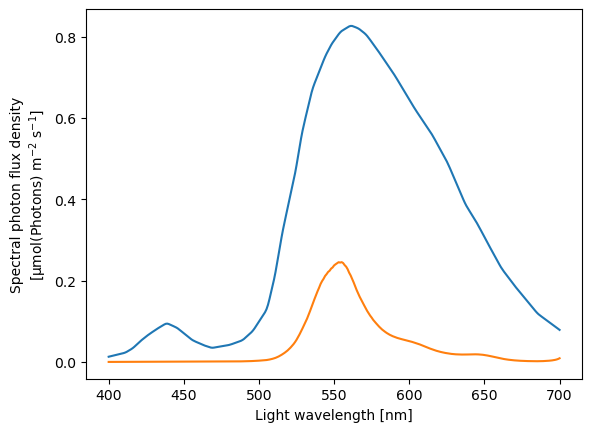

In [100]:
fig, ax = plot_spectra(test["orig_pfd"])
fig, ax = plot_spectra(test["pfd"], ax=ax)

## Fit the regression function

In [102]:
run_prefix = "rateregression_202407012302"

result = pd.read_csv(f"../Results/{run_prefix}_results.csv", index_col=0)
input = pd.read_csv(f"../Results/{run_prefix}_params.csv", index_col=0)

array([<Axes: >, <Axes: >, <Axes: >, <Axes: >], dtype=object)

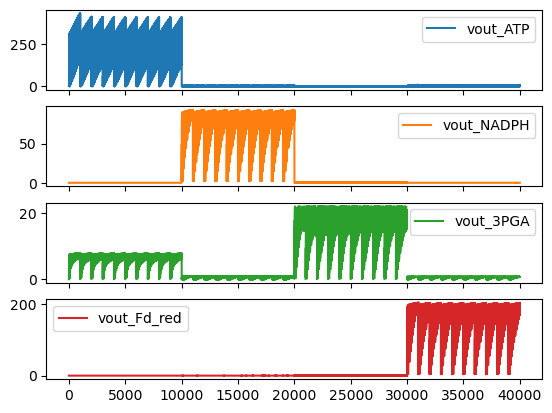

In [105]:
result.plot(subplots=True)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import mean_squared_error

# Exclude the failed simulations
failed_simulations = result.isna().any(axis=1)

# Generate some sample data
X = input[np.invert(failed_simulations)]
y = result.loc[np.invert(failed_simulations), :].to_numpy()

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Degree of the polynomial
degree = 5

# Create polynomial features
polynomial_features = PolynomialFeatures(degree=degree)

# Create a base regressor
base_regressor = LinearRegression()

# Wrap the regressor with MultiOutputRegressor
multi_target_regressor = MultiOutputRegressor(base_regressor)

# Create a pipeline that combines the polynomial features and the linear regression model
model = make_pipeline(polynomial_features, multi_target_regressor)

# Fit the model
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse}")

Mean Squared Error: 0.32623867727460565


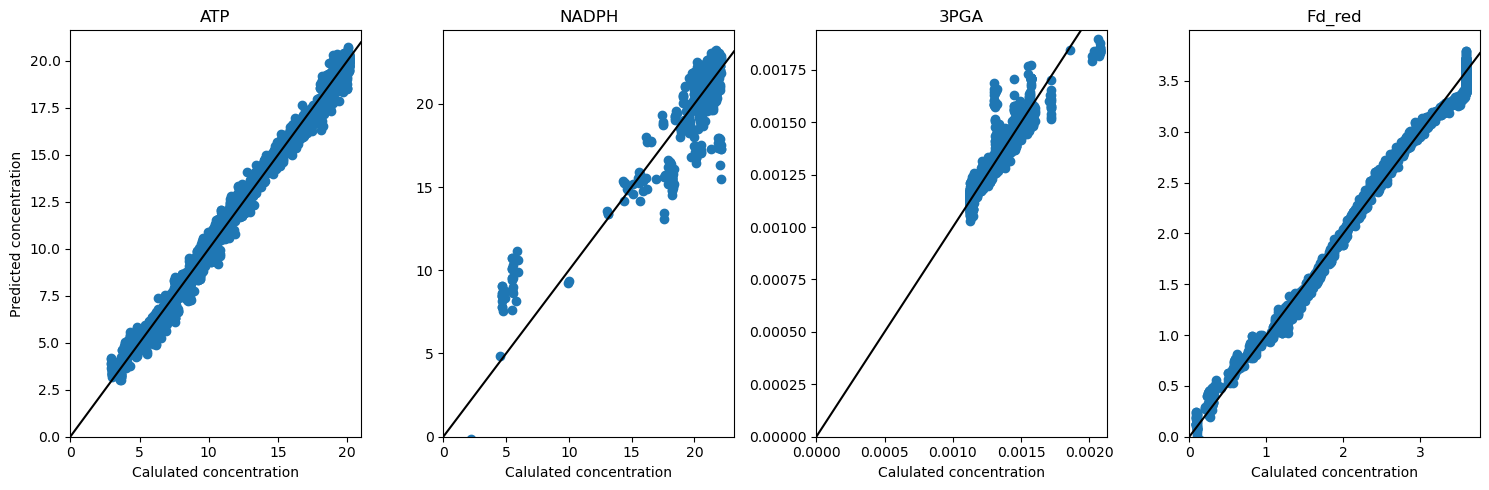

In [ ]:
fig, axes = plt.subplots(1,4, figsize=(15,5))

for i, ax in enumerate(axes.flatten()):
    ax.plot(y_test[:,i], y_pred[:,i], ls="", marker="o")
    ax.set_xlabel("Calulated concentration")
    if i == 0:
        ax.set_ylabel("Predicted concentration")
    ax.set_xlim(0)
    ax.set_ylim(0)
    ax.set_title(result.columns[i])

    min_lim, maxlim = np.array([ax.get_ylim(), ax.get_xlim()]).min(axis=0)

    ax.plot((min_lim, maxlim), (min_lim, maxlim), c="k")

fig.tight_layout()

In [ ]:
# import pickle
# with open("../Results/concentration_regression_model.pickle", "wb") as f:
#     pickle.dump(model, f)